# Clustering

Permite agrupar observaciones o datos que son similares entre sí. Veamos cómo usar varios algoritmos de clustering, y cómo visualizar los datos.


# K-Means

K-means es un método para particionar datos en distintos clusters, que intenta minimizar la distancia de cada punto de un cluster a su centroide.



**Datos:**
Usaremos un conjunto de datos de juguete sobre valoraciones de películas. Cada observación corresponde a los ratings que un usuario dio a ciertas películas, por lo que cada atributo es el rating de una película en particular.
Nuestro objetivo es **identificar grupos de usuarios con preferencias cinematográficas similares**.

In [ ]:
import pandas as pd

ratings = [['john', 5, 5, 2, 1],
           ['mary', 4, 5, 3, 2],
           ['bob', 4, 4, 4, 3],
           ['erik', 5, 4, 1, 1],
           ['jhossua', 4, 4, 2, 2],
           ['lisa', 2, 2, 4, 5],
           ['lee', 1, 2, 3, 4],
           ['harry', 2, 1, 5, 5],
           ['mary', 1, 1, 3, 5],
           ['jane', 2, 1, 5, 4]]

titles = ['user', 'Jaws', 'Star Wars', 'Exorcist', 'Omen']
movies = pd.DataFrame(ratings, columns=titles)
movies

,user,Jaws,Star Wars,Exorcist,Omen
0,john,5,5,2,1
1,mary,4,5,3,2
2,bob,4,4,4,3
3,erik,5,4,1,1
4,jhossua,4,4,2,2
5,lisa,2,2,4,5
6,lee,1,2,3,4
7,harry,2,1,5,5
8,mary,1,1,3,5
9,jane,2,1,5,4


**¿Cómo visualizamos nuestros datos?**

---

Si tuvieramos 2 dimensiones podríamos graficarlos directamente. En este caso, tenemos que reducir la dimensionalidad, para lo cual se pueden usar métodos como PCA y T-SNE.

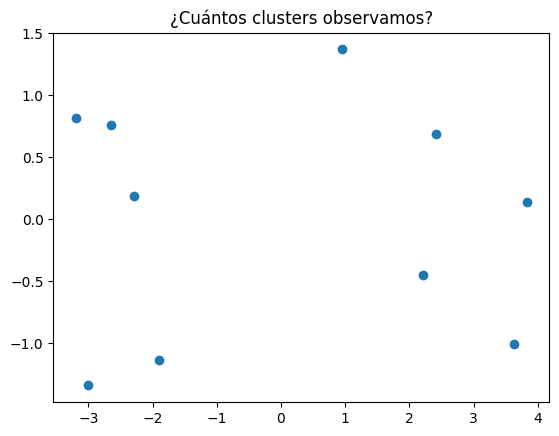

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Eliminamos la columna user, ya que es sólo un identificador
rates = movies.drop(columns=['user'])

pca = PCA(n_components=2).fit(rates)
rates_pca = pca.transform(rates)

plt.scatter(rates_pca[:, 0], rates_pca[:, 1])
plt.title("¿Cuántos clusters observamos?")
plt.show()

Ejecutamos k-means y le indicamos que queremos que divida los datos en 2 clusters:

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, n_init=20, max_iter=50, random_state=1)
kmeans.fit(rates) #`fit_predict` entrena el modelo y devuelve las predicciones

KMeans(max_iter=50, n_clusters=2, n_init=20, random_state=1)

Creamos un objeto KMeans, que está configurado para asignar 2 clusters. Ejecutamos el método `n_init` veces, donde cada vez se generan centroides que parten aleatoriamente (se queda con el resultado con menor error). `max_iter` indica el número máximo de iteraciones que hará el modelo en caso de no converger antes.

Con el objeto **kmeans** entrenado podemos preguntar por algunos de los resultados.

* *cluster_centers_:* centroides finales del modelo.

* *labels_:* asignaciones de cada ejemplo (y_pred).

* *inertia_:* error de los clusters.

* *n_iter_:* iteraciones para encontrar este resultado.


In [ ]:
y_pred = kmeans.labels_ #kmeans.predict(rates)
y_pred

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
# centroides resultantes del clustering
centroids = kmeans.cluster_centers_
pd.DataFrame(centroids, columns=rates.columns)

,Jaws,Star Wars,Exorcist,Omen
0,1.6,1.4,4.0,4.6
1,4.4,4.4,2.4,1.8


In [ ]:
centroids_pca = pca.transform(centroids)
pd.DataFrame(centroids_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


,0,1
0,-2.605255,-0.145768
1,2.605255,0.145768


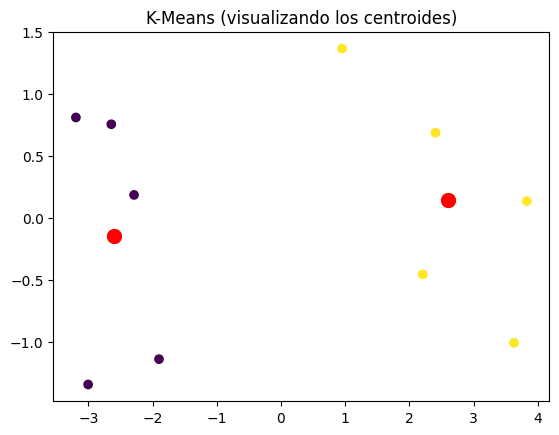

In [ ]:
plt.scatter(rates_pca[:, 0], rates_pca[:, 1], c=kmeans.labels_)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], s=100, facecolors='r')
plt.title("K-Means (visualizando los centroides)")
plt.show()

Ahora podemos usar nuestro modelo con datos nuevos, es decir, le podríamos pasar nuevas evaluaciones de películas y el clustering nos indicará a cuál cluster corresponden, similar a la clasificación:

In [ ]:
testData = [[4, 5, 1, 2],
            [3, 2, 4, 4],
            [2, 3, 4, 1],
            [3, 2, 3, 3],
            [5, 4, 1, 4]]

testData = pd.DataFrame(testData, columns=['Jaws', 'Star Wars', 'Exorcist', 'Omen'])

testData['Cluster_ID'] = kmeans.predict(testData) #tener cuidado al agregar esta columna, pues (erróneamente) podrían usarla a futuro en las variables para estimar otro modelo de clustering
testData

,Jaws,Star Wars,Exorcist,Omen,Cluster_ID
0,4,5,1,2,1
1,3,2,4,4,0
2,2,3,4,1,1
3,3,2,3,3,0
4,5,4,1,4,1


**¿Podría haber más de dos clusters?**

---

Una tecnica para encontrar un número razonable de clusters a usar es el **método del codo**, donde calculamos la suma de la diferencia al cuadrado entre los puntos de cada cluster (SSE, que en `scikit-learn` es la `inertia_`) para varios números de clusters y graficamos como varía, eligiendo el "mejor". Este concepto de "mejor" no es claro, pero la idea es elegir el último cluster antes de encontrarnos con el punto de _diminishing returns_, que sería cuando aumentar a más clusters nos da una mejora muy pequeña respecto a la que estamos considerando actualmente.

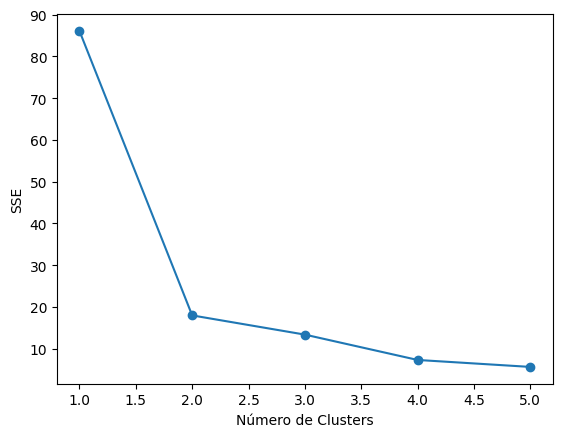

In [ ]:
SSE = []
numClusters = list(range(1, 6))
for k in numClusters:
    k_means = KMeans(n_clusters=k, n_init='auto')
    k_means.fit(rates)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE, marker="o")
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()

Observamos que el "codo" se encuentra claramente marcado en dos clusters.

# Clustering Jerárquico Aglomerativo

En este método lo que hacemos es partir con que cada dato es un cluster independiente de los demás, y luego, mediante una matriz de distancias vamos uniendo datos, creando anidaciones de clusters. Continuamos hasta que quede solo 1 cluster muy grande (o k clusters).

Generalmente estos métodos se grafican como un dendrograma, y usan la distancia euclidiana para calcular las matrices de distancias. Se pueden usar otras métricas de distancia/similitud.

Vamos a presentar 4 criterios para ir uniendo los clusters. Estos corresponden a `complete`, `average`, `single` y `ward`. Aquí una descripción rápida de los criterios:
* `complete`: considera la distancia máxima entre 2 clusters
* `average`: considera la distancia promedio entre 2 clusters
* `single`: considera la distancia mínima entre 2 clusters
* `ward`: minimiza la varianza entre los 2 clusters

**Datos:**
Usaremos un conjunto de datos de animales vertebrados, pertenecientes a una de las 5 categorías: *mamíferos, reptiles, aves, peces y anfibios*, basándose en un conjunto de atributos explicativos. Salvo la variable "Name", el resto de los atributos se han convertido en una representación binaria (one hot encoding).

In [ ]:
data = pd.read_csv('http://www.cse.msu.edu/~ptan/dmbook/tutorials/tutorial8/vertebrate.csv')
data

,Name,Warm-blooded,Gives Birth,Aquatic Creature,Aerial Creature,Has Legs,Hibernates,Class
0,human,1,1,0,0,1,0,mammals
1,python,0,0,0,0,0,1,reptiles
2,salmon,0,0,1,0,0,0,fishes
3,whale,1,1,1,0,0,0,mammals
4,frog,0,0,1,0,1,1,amphibians
5,komodo,0,0,0,0,1,0,reptiles
6,bat,1,1,0,1,1,1,mammals
7,pigeon,1,0,0,1,1,0,birds
8,cat,1,1,0,0,1,0,mammals
9,leopard shark,0,1,1,0,0,0,fishes


Para trabajar con clustering jerárquico podemos usar `scikit-learn` o `scipy`. `scikit-learn` no tiene una forma directa de graficar los dendrogramas, pero `scipy` sí.

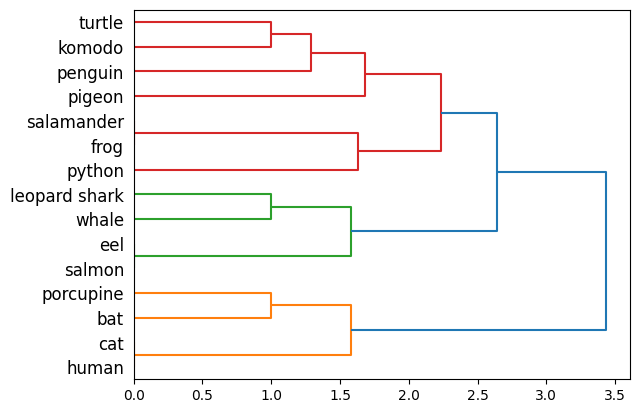

In [ ]:
# revisar funciones de distancia/similitud:
# euclidiana, manhattan o cityblock, correlacion, coseno

from scipy.cluster.hierarchy import dendrogram, linkage

names = data['Name']
Y = data['Class']
X = data.drop(['Name','Class'], axis=1) #ocuparemos únicamente los atributos

Z = linkage(X, 'ward', metric='euclidean') #matriz de similitud
dn = dendrogram(Z, labels=names.tolist(), orientation='right')

Visualmente podemos considerar que 3 o 4 clusters es un número razonable. Podemos cortar el arbol en distintos puntos para ver cómo se distribuyen los datos en las ramas. Luego manualente decidir viendo el dendrograma cuál sería una buena distancia para cortar el árbol.

Por ejemplo, en el caso de complete, 0.8 parece ser un buen número para cortar.

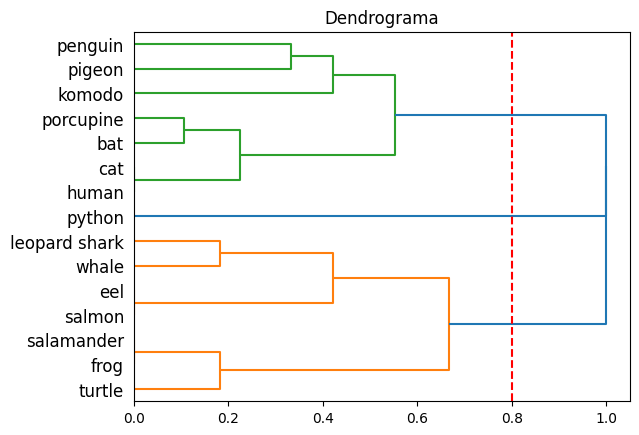

In [ ]:
Z = linkage(X, method='complete', metric='cosine') # max
dn = dendrogram(Z, labels=names.tolist(),orientation='right')

plt.title("Dendrograma")
plt.axvline(x=0.8, color='r', linestyle='--')
plt.show()

Hasta ahora solo hemos graficado los árboles (para saber cuántos clusters queremos), pero no hemos etiquetado los datos. Ahora podemos usar `scikit-learn` con `AgglomerativeClustering`. Podemos usar el parametro `n_clusters` o el parametro `distance_threshold` (distancia que queremos cortar).

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agl_ncluster = AgglomerativeClustering(linkage="complete",
                                        metric='cosine',
                                        n_clusters=3).fit(X)

print(agl_ncluster.n_clusters_)
print(agl_ncluster.labels_)

3
[1 2 0 0 0 1 1 1 1 0 0 1 1 0 0]


In [ ]:
agl_distance = AgglomerativeClustering(linkage="complete",
                                       metric='cosine',
                                       n_clusters=None,
                                       distance_threshold=0.8).fit(X)
print(agl_distance.n_clusters_)
print(agl_distance.labels_)

3
[1 2 0 0 0 1 1 1 1 0 0 1 1 0 0]


Visualicemos nuestros clusters pintando cada dato del color asignado a cada cluster.

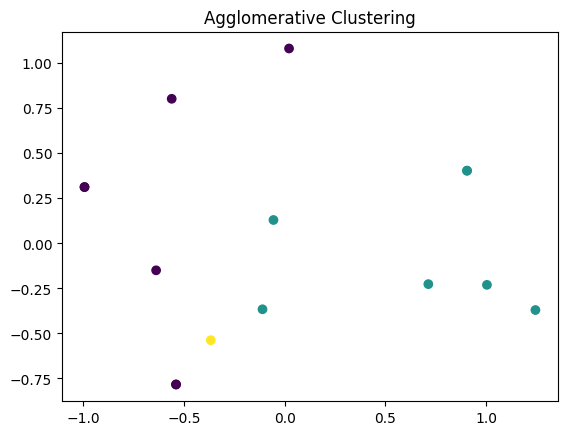

In [ ]:
pca = PCA(n_components=2).fit(X)
X_pca = pca.transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agl_distance.labels_)
plt.title("Agglomerative Clustering")
plt.show()

# DBScan

Algoritmo de clustering basado en densidad. DBSCAN está implementado en `scikit-learn` y necesita de los parametros `eps` y `min_samples`. `eps` corresponde a la distancia dentro de la cual se consideran 2 puntos vecinos, `min_samples` es el número de vecinos que tiene que tener un punto para ser considerado un punto _core_.

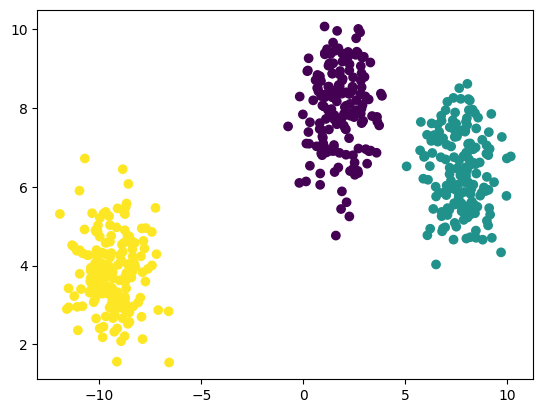

In [ ]:
from sklearn import datasets

# Generamos 500 datos con 2 features aleatorias, centrado alrededor de 3 centroides
X, y = datasets.make_blobs(n_samples=500, n_features=2,
                           centers=3, random_state=20)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()


Esta implementación asocia los puntos de ruido al cluster ID con valor `-1`.

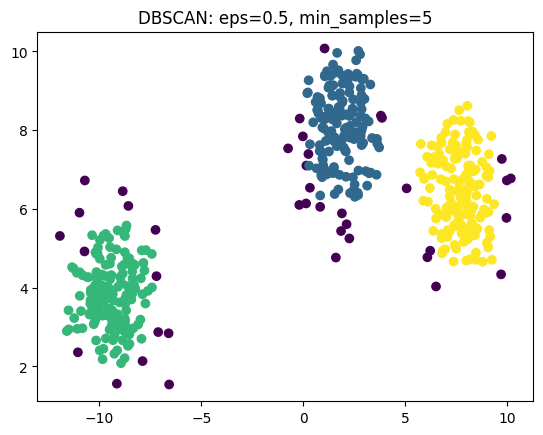

In [ ]:
from sklearn.cluster import DBSCAN

eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
plt.scatter(X[:,0], X[:,1], c=dbscan.labels_)
plt.title(f"DBSCAN: eps={eps}, min_samples={min_samples}")
plt.show()

En este caso podemos ver que dice que hay 4 "clusters", de los cuales 3 son clusters reales y el resto es considerado como ruido. `eps` es el parametro más importante de DBSCAN, por lo que tenemos que elegirlo con cuidado.

**Estimación del `eps` usando el `método de la rodilla` (basado en KNN).**

____


Para esto, vamos a fijar un valor de `minPts`.
Luego vamos a graficar la distancia de cada punto del dataset a su `minPts` vecino más cercano.
La idea es calcular la distancia promedio de cada punto a sus vecinos más cercanos los cuales son graficados en orden ascendente. El objetivo es determinar la `rodilla`, que corresponde al valor óptimo de `eps`.

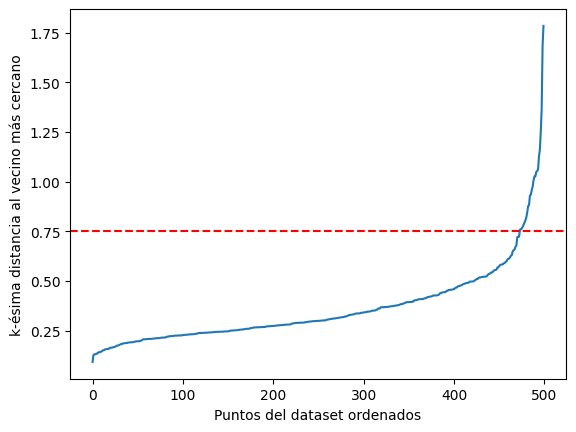

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

N = 5
nbrs = NearestNeighbors(n_neighbors=N).fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,N-1]
plt.plot(distances)
plt.axhline(y=0.75, color='r', linestyle='--') #Ajuste el valor para y
plt.xlabel('Puntos del dataset ordenados')
plt.ylabel('k-ésima distancia al vecino más cercano');

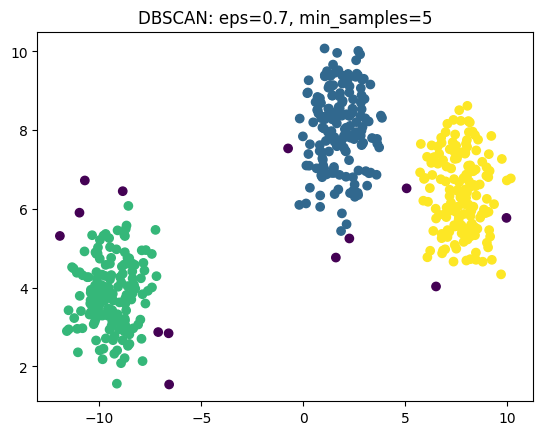

In [ ]:
eps = 0.7
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
plt.scatter(X[:,0], X[:,1], c=dbscan.labels_)
plt.title(f"DBSCAN: eps={eps}, min_samples={min_samples}")
plt.show()

**Referencias**

Software and Tutorials: http://www.cse.msu.edu/~ptan/dmbook/software/